# 6imilarité group 2

### Introduction

In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
import shutil
import zipfile
import random
import torchvision
import numpy as np
from sklearn.utils.class_weight import compute_class_weight
import torchvision.transforms as transforms

import torch
import torch.nn as nn
import torch.optim as optim

import torchvision.models as models

import time
from tqdm import tqdm

import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
from typing import Tuple, Dict, Any, List


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
print(torch.cuda.get_device_name(device))

cuda
NVIDIA A2


### Download the data

In [2]:
#!pip install kaggle
# Retrive you kaggle credentials inside your kaggle account and put the kaggle.json file inside /home/onyxia/.kaggle/ 
!kaggle datasets download jutrera/stanford-car-dataset-by-classes-folder

Dataset URL: https://www.kaggle.com/datasets/jutrera/stanford-car-dataset-by-classes-folder
License(s): other
100%|█████████████████████████████████████▉| 1.82G/1.83G [00:55<00:00, 35.9MB/s]
100%|██████████████████████████████████████| 1.83G/1.83G [00:55<00:00, 35.2MB/s]


### Useful variables and functions

In [4]:
DATA_PATH = "data/car_data/car_data/"
TRAIN_PATH = "data/car_data/car_data/train"
VAL_PATH = "data/car_data/car_data/val"
TEST_PATH = "data/car_data/car_data/test"

In [3]:
# Create "data/" directory
def create_dir(directory_path: str) -> None:
    if not os.path.exists(directory_path):
        os.makedirs(directory_path)

# Décompresser les données
def unzip_data() -> None:
    with zipfile.ZipFile("stanford-car-dataset-by-classes-folder.zip", "r") as zip_file:
        zip_file.extractall("data/")

# Split the initial test data into the training and validation data
def split_initial_test_folder() -> None:
    for class_folder in os.listdir(TEST_PATH):
        create_dir(os.path.join(VAL_PATH, class_folder))
        
        for i, image_name in enumerate(os.listdir(os.path.join(TEST_PATH, class_folder))):
            if i % 5 == 0: # Move 1/5 of data inside training dataset
                shutil.move(os.path.join(TEST_PATH, class_folder, image_name), os.path.join(TRAIN_PATH, class_folder, image_name))
            elif i % 5 < 3: # Move 2/5 of data inside validation dataset
                shutil.move(os.path.join(TEST_PATH, class_folder, image_name), os.path.join(VAL_PATH, class_folder, image_name))

### Loading and split the data from zip

In [6]:
if os.path.exists(VAL_PATH):
    print("Repartion already exist")
else:
    create_dir("data")
    unzip_data()
    split_initial_test_folder()

### Compute the sample repartition

In [7]:
count_train, count_val, count_test = 0, 0, 0
for class_folder in os.listdir(TRAIN_PATH):
    count_train += len(os.listdir(os.path.join(TRAIN_PATH, class_folder)))
for class_folder in os.listdir(VAL_PATH):
    count_val += len(os.listdir(os.path.join(VAL_PATH, class_folder)))
for class_folder in os.listdir(TEST_PATH):
    count_test += len(os.listdir(os.path.join(TEST_PATH, class_folder)))

total = count_train + count_val + count_test
print(f"Total data {total}, train:{round(count_train / total, 2)}, validation: {round(count_val / total, 2)}, test:{round(count_test / total, 2)}")
assert len(os.listdir(TRAIN_PATH)) == len(os.listdir(VAL_PATH)) == len(os.listdir(TEST_PATH))

Total data 16181, train:0.61, validation: 0.2, test:0.19


## Loading and displaying the data

### Plot images

In [10]:
def truncate_string(string: str, max_length: int) -> str:
    if len(string) > max_length:
        return string[:max_length - 3] + " [...]"
    else:
        return string

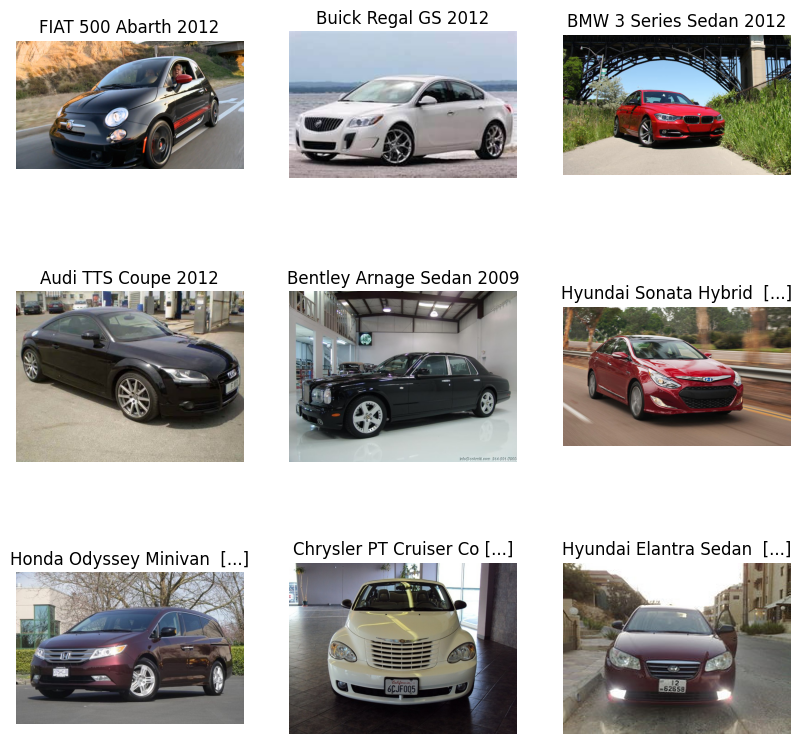

In [11]:
plt.figure(figsize=(10, 10))
classes_directory = random.choices(os.listdir(TRAIN_PATH), k=9)

for i, class_name in enumerate(classes_directory):
    sample_filename = random.choice(os.listdir(os.path.join(TRAIN_PATH, class_name)))
    image_path = os.path.join(TRAIN_PATH, class_name, sample_filename)
    image = Image.open(image_path)
    
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(image)
    plt.title(truncate_string(class_name, 25))
    plt.axis("off")

### Bar Chart of the class weight in training dataset

In [12]:
car_count_dict = {}

for class_folder in os.listdir(TRAIN_PATH):
    count = len(os.listdir(os.path.join(TRAIN_PATH, class_folder)))
    car_count_dict[class_folder] = count

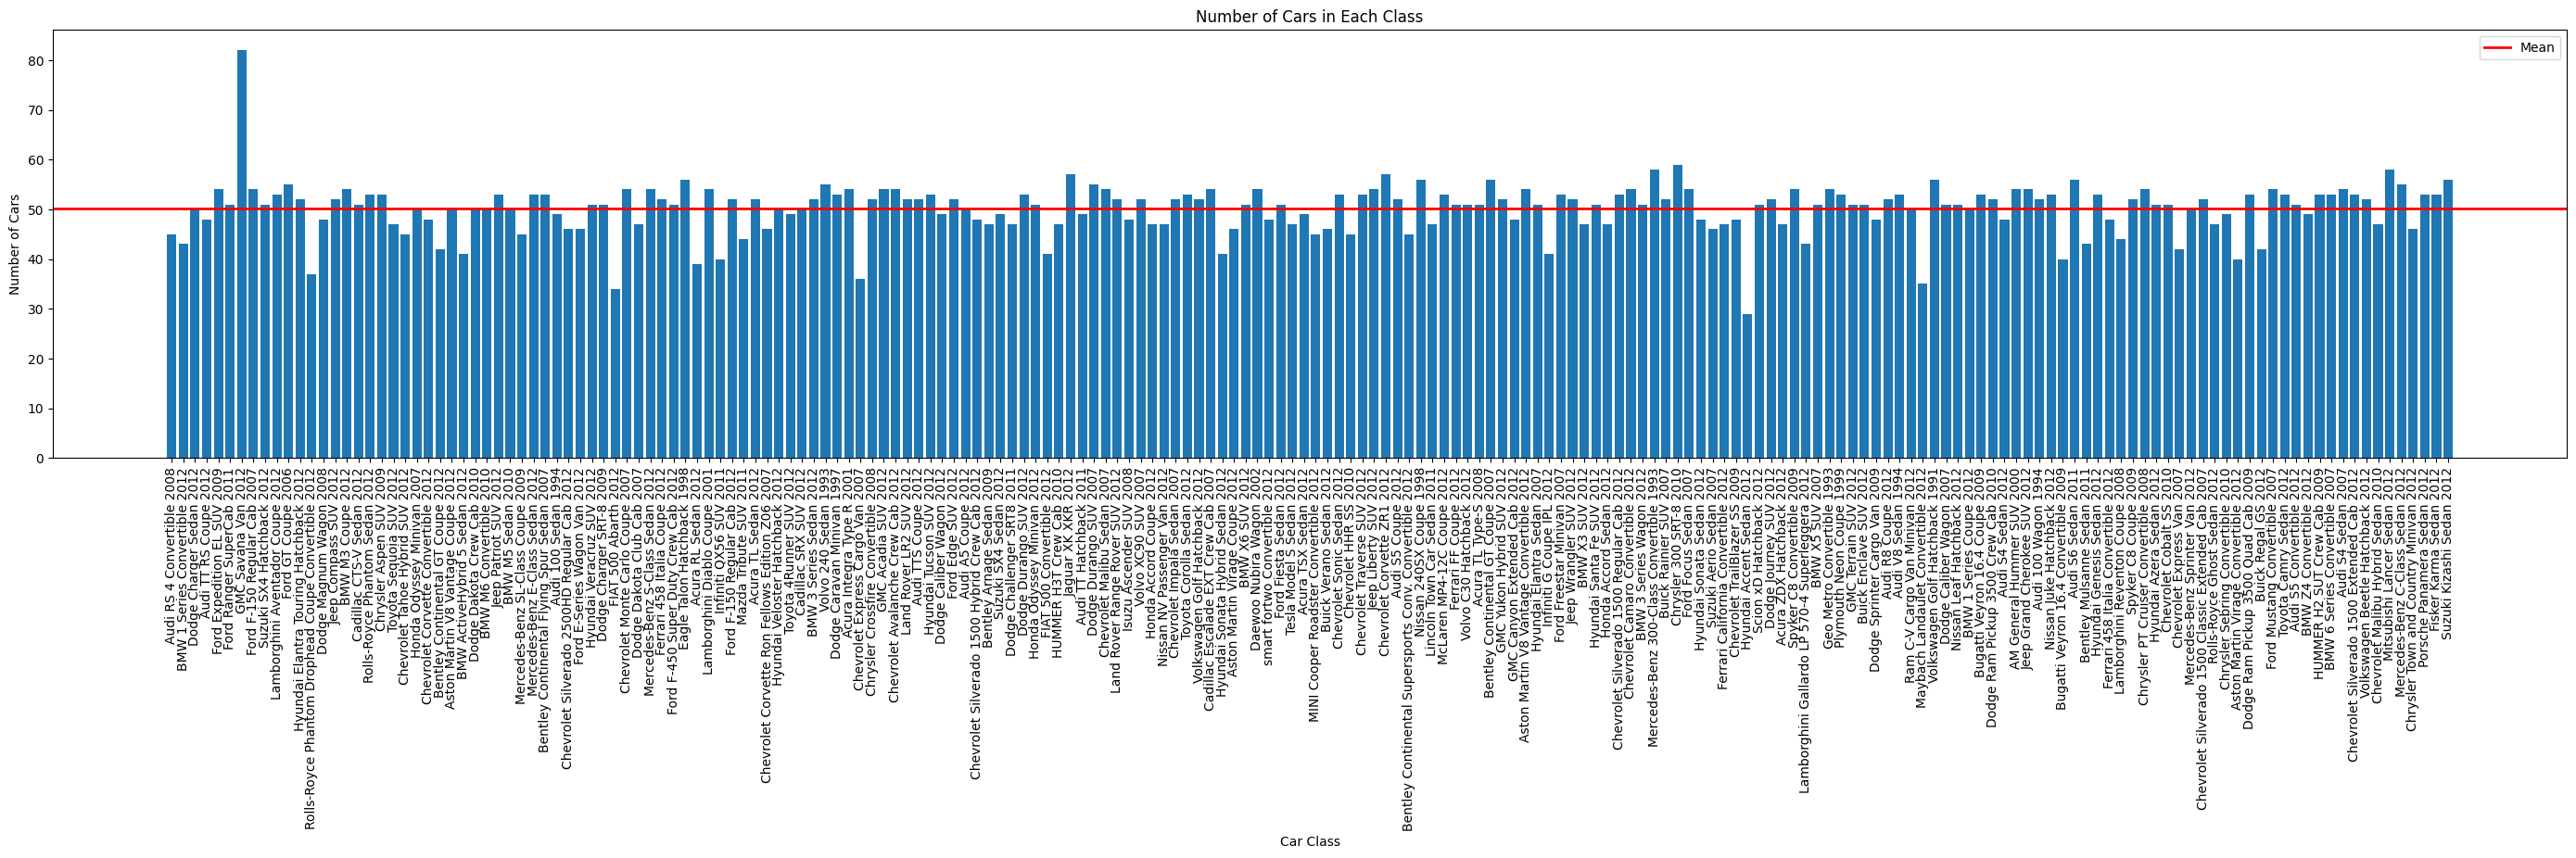

In [13]:
plt.figure(figsize=(35, 6))
plt.bar(car_count_dict.keys(), car_count_dict.values())

plt.xlabel('Car Class')
plt.ylabel('Number of Cars')
plt.title('Number of Cars in Each Class inside the training dataset')

# Calculating the mean of car counts
mean_value = np.mean(list(car_count_dict.values()))
plt.axhline(y=mean_value, color='r', linestyle='-', linewidth=2, label='Mean')
plt.legend()

plt.xticks(rotation=90)
plt.show()

In [8]:
car_count_dict = {}

for class_folder in os.listdir(TEST_PATH):
    count = len(os.listdir(os.path.join(TEST_PATH, class_folder)))
    car_count_dict[class_folder] = count

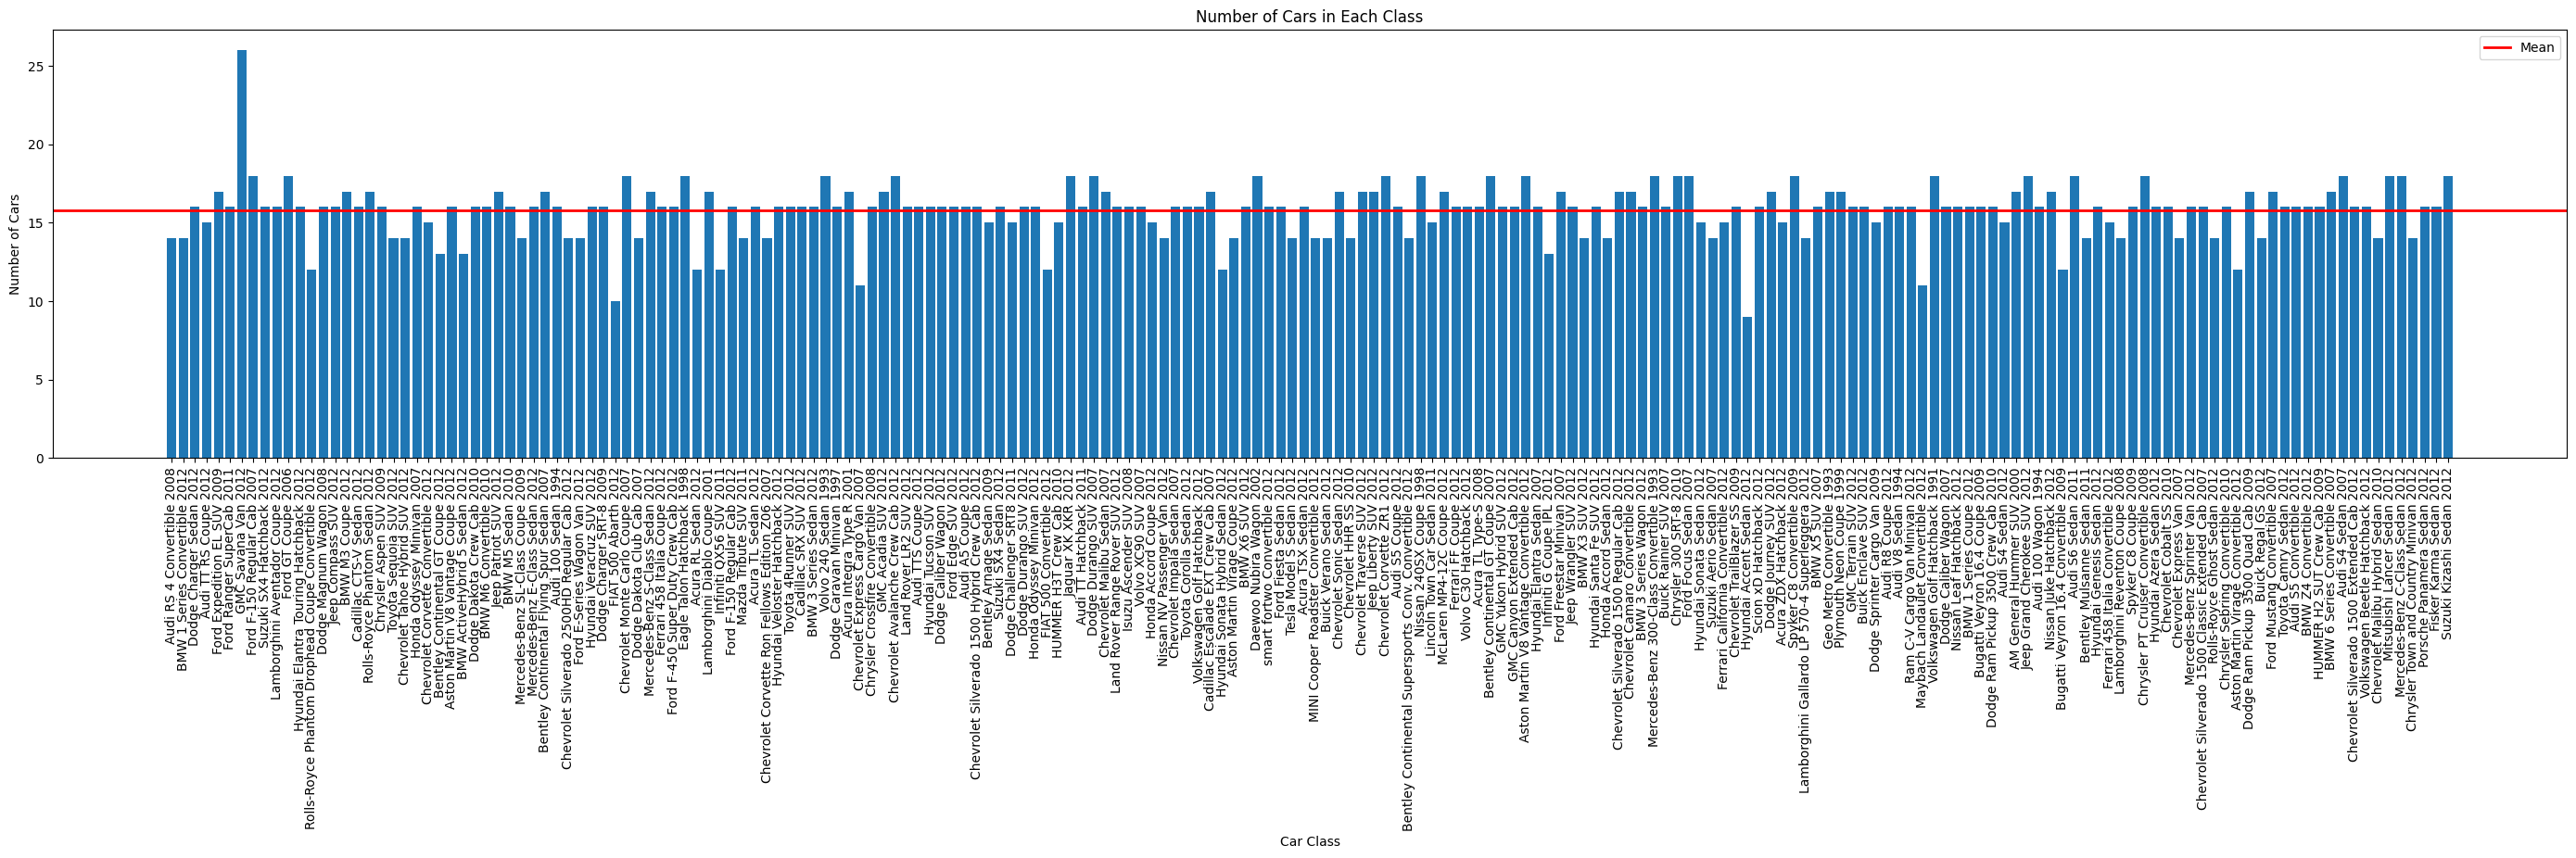

In [9]:
plt.figure(figsize=(35, 6))
plt.bar(car_count_dict.keys(), car_count_dict.values())

plt.xlabel('Car Class')
plt.ylabel('Number of Cars')
plt.title('Number of Cars in Each Class inside the test dataset')

# Calculating the mean of car counts
mean_value = np.mean(list(car_count_dict.values()))
plt.axhline(y=mean_value, color='r', linestyle='-', linewidth=2, label='Mean')
plt.legend()

plt.xticks(rotation=90)
plt.show()

### Get the average size of images in the training Dataset

In [14]:
height, width = [], []
for class_folder in os.listdir(os.path.join(DATA_PATH, 'train')):
    for image_filename in os.listdir(os.path.join(DATA_PATH, 'train', class_folder)):
        image_path = os.path.join(DATA_PATH, 'train', class_folder, image_filename)
        image = Image.open(image_path)
        height.append(image.height)
        width.append(image.width)

mean_height = round(np.mean(np.array(height)))
mean_width = round(np.mean(np.array(width)))

print(f"{mean_width = }, {mean_height = }")

mean_width = 698, mean_height = 482


## Data augmentation

In [15]:
import multiprocessing

num_cores = multiprocessing.cpu_count()
print(f"{num_cores = }")

num_cores = 104


In [16]:
# Imported from ImageNet
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

In [17]:
# defining the transformation for the dataset
train_augmentation = transforms.Compose([transforms.Resize((224, 224)),
                                transforms.RandomHorizontalFlip(),
                                transforms.RandomRotation(15),
                                transforms.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.3, hue=0.2),
                                transforms.ToTensor(),
                                transforms.Normalize(mean, std)])

val_train_augmentation = transforms.Compose([transforms.Resize((224, 224)), #400
                                transforms.ToTensor(),
                                transforms.Normalize(mean, std)])

test_train_augmentation = transforms.Compose([transforms.Resize((224, 224)), #400
                                transforms.ToTensor(),
                                transforms.Normalize(mean, std)])

In [18]:
BATCH_SIZE = 32

train_dataset = torchvision.datasets.ImageFolder(root=TRAIN_PATH, transform = train_augmentation)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size = BATCH_SIZE, shuffle=True, num_workers = num_cores)

val_dataset = torchvision.datasets.ImageFolder(root=TEST_PATH, transform = val_train_augmentation)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size = BATCH_SIZE, shuffle=False, num_workers = num_cores)

test_dataset = torchvision.datasets.ImageFolder(root=TEST_PATH, transform = test_train_augmentation)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size = BATCH_SIZE, shuffle=False, num_workers = num_cores)

### Creating the model

In [19]:
model = models.resnet18(progress=True, pretrained=True)

num_ftrs = model.fc.in_features
no_classes = len(train_dataset.classes)

# Adapt the last dense layer for the 200 avalaible classes
model.fc = nn.Linear(num_ftrs, no_classes)

/opt/mamba/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/mamba/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


### Display thee model architecture

In [20]:
model.parameters

<bound method Module.parameters of ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)


### Compute Class weights

In [21]:
# Transform string labels into int labels
counter = 0
label_to_int = {}

for class_name in os.listdir(TRAIN_PATH):
    label_to_int[class_name] = counter
    counter += 1

sample_to_int = []
for class_folder in os.listdir(TRAIN_PATH):
    for _ in os.listdir(os.path.join(TRAIN_PATH, class_folder)):
        sample_to_int.append(label_to_int[class_folder])

y = np.array(sample_to_int)

# Compute class weights
class_weights = compute_class_weight(class_weight="balanced", classes=np.unique(y), y=y)

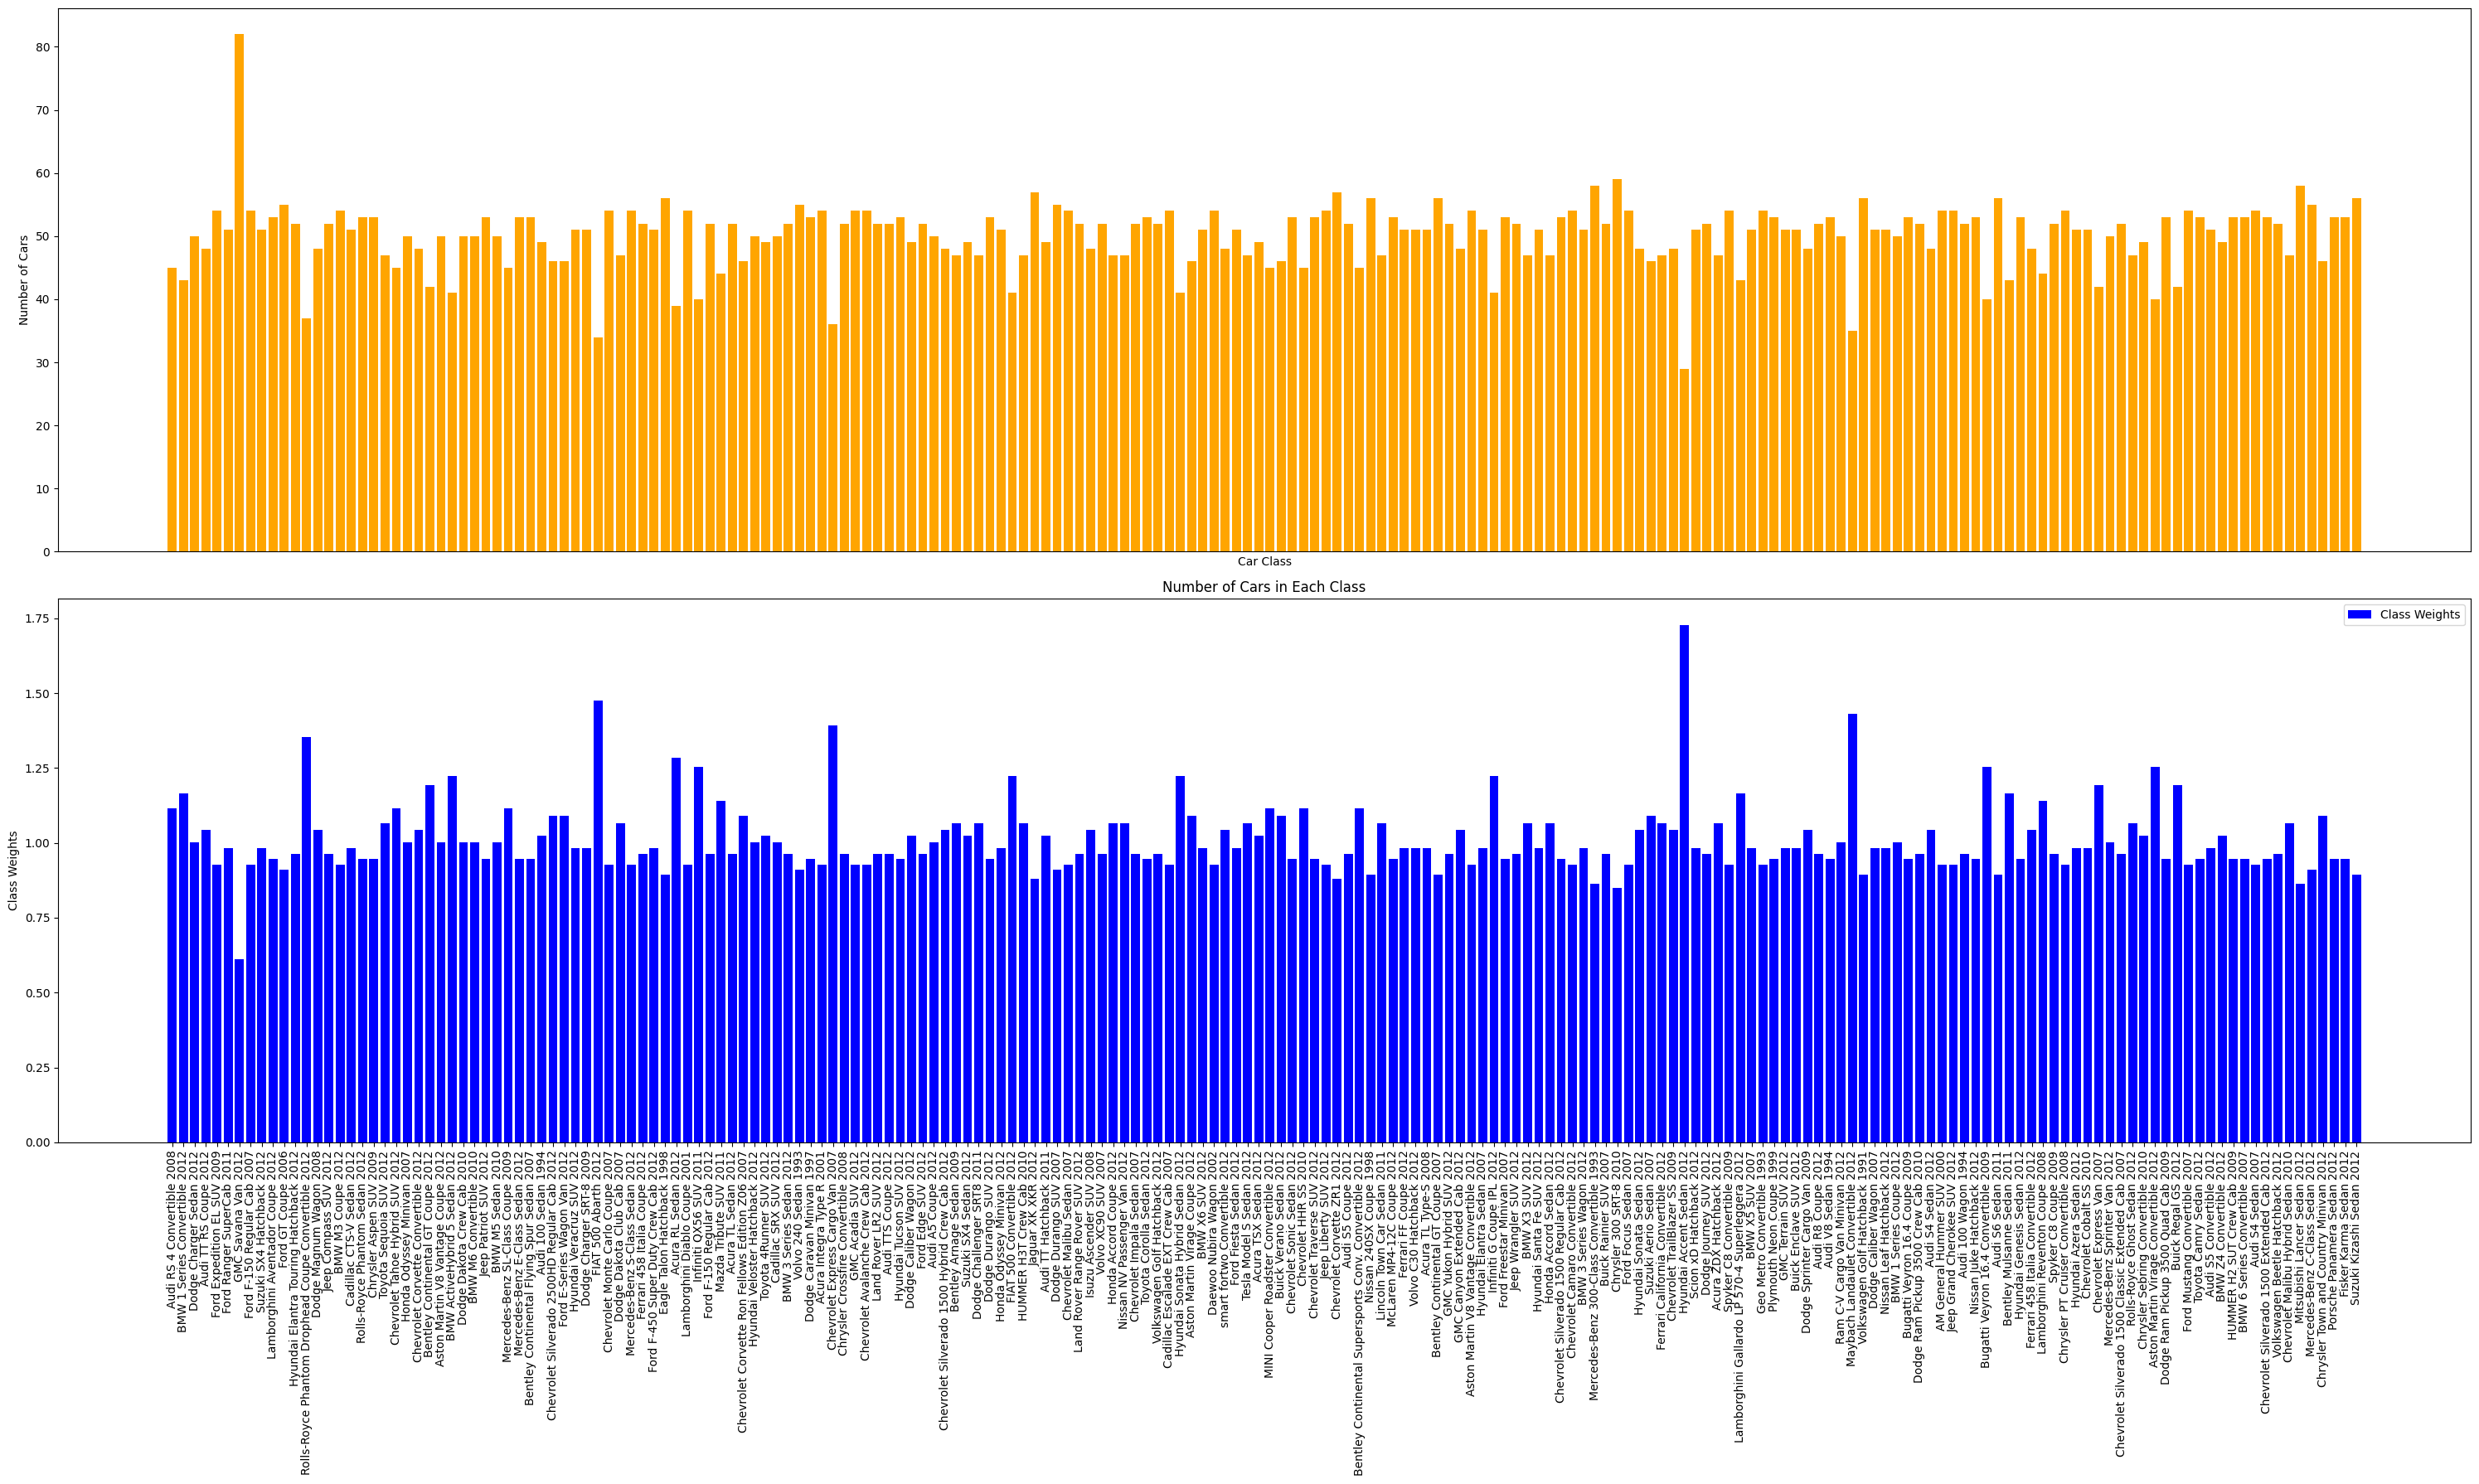

In [22]:
# Create a figure and two subplots side by side
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(30, 18))

# Plot the first bar graph on the first subplot (top)
ax1.bar(car_count_dict.keys(), car_count_dict.values(), color='orange', label='Car Count')
ax1.set_xlabel('Car Class')
ax1.set_ylabel('Number of Cars')
ax1.set_xticks([])

# Plot the second bar graph on the second subplot (bottom)
ax2.bar(car_count_dict.keys(), class_weights, color='blue', label='Class Weights')
ax2.set_ylabel('Class Weights')
ax2.set_title('Number of Cars in Each Class')
ax2.legend()

# Rotate x-axis labels for better visibility
plt.setp(ax2.get_xticklabels(), rotation=90)

# Adjust layout to prevent overlap
plt.tight_layout()

# Show the plot
plt.show()

### Setting the Hyper-Parameters 

In [23]:
model = model.to(device)

# Defining the loss function and the optimizer
class_weights = torch.tensor(class_weights, dtype=torch.float32, device=device)
criterion = nn.CrossEntropyLoss(weight=class_weights, label_smoothing=0.02)
optimizer = optim.Adam(model.parameters(), weight_decay=5e-5) # weight_decay == L2 (riddge)

In [24]:
lrscheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min',factor=0.1, patience=2, min_lr=0.00001, verbose=True)

/opt/mamba/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


## Training the model

In [25]:
# Evaluate the model via the test dataset and generate predictions.
def eval_model(model: nn.Module, val_loader: torch.utils.data.DataLoader,
               device: torch.device) -> Tuple[float, float]:
    correct = 0.0
    total = 0.0
    running_loss = 0.0

    # Set the model to eval
    model.eval()
    
    # Forward propagation only (no training on test dataset)
    with torch.no_grad():
        for i, data in enumerate(val_loader, 0):
            images, labels = data
            
            # Transfer to GPU
            images = images.to(device)
            labels = labels.to(device)

            # Forward propagation
            outputs = model(images)
            
            # Get predictions from the maximum value 
            _, predicted = torch.max(outputs.data, 1)

            # Calculate the loss
            loss = criterion(outputs, labels)
            
            # Total number of labels in the test data set
            total += labels.size(0)
            
            # Total correct predictions
            running_loss += loss.item()
            correct += (predicted == labels).sum().item()
    
    # Calculate the accuracy
    test_accuracy = correct / (BATCH_SIZE * len(test_loader))
    test_loss = running_loss / len(test_loader)
    return test_accuracy, test_loss

In [26]:
def train_model(model: nn.Module, train_loader: torch.utils.data.DataLoader, val_loader: torch.utils.data.DataLoader,
                criterion: nn.Module, optimizer: optim.Optimizer, scheduler: optim.lr_scheduler.ReduceLROnPlateau,
                device: torch.device, n_epochs: int = 5) -> Dict[str, List[float]]:
    
    history: Dict[str, List[float]] = {
        "losses": [],
        "accuracies": [],
        "test_accuracies": [],
        "test_losses": [],
        "lr": []
    }

    for epoch in range(n_epochs):
        since = time.time()
        running_loss = 0.0
        running_correct = 0.0

        # set the model to train mode initially
        # (This is important as some models behave differently in train and test time.)
        model.train()

        with tqdm(train_loader, unit="batch", desc=f"Epoch {epoch + 1}") as training_epoch:
            for i, data in enumerate(training_epoch):
                inputs, labels = data

                # Transfer to GPU
                inputs = inputs.to(device)
                labels = labels.to(device)

                # Zero the parameter gradients
                optimizer.zero_grad()
                
                # Forward propagation
                outputs = model(inputs)
                # Get predictions from the maximum value
                _, predicted = torch.max(outputs.data, 1)
                
                # Calculate the loss
                loss = criterion(outputs, labels)
                
                # Backward pass
                loss.backward()
                # Optimize the weights
                optimizer.step()
                
                # Calculate the loss and The accuracy
                running_loss += loss.item()
                running_correct += (labels==predicted).sum().item()
        
        # Compute and appen metric values
        epoch_acc = running_correct / (BATCH_SIZE * len(train_loader))
        epoch_loss = running_loss / len(train_loader)

        history['losses'].append(epoch_loss)
        history['accuracies'].append(epoch_acc)
                
        test_acc, test_loss = eval_model(model, val_loader, device)
        history['test_accuracies'].append(test_acc)
        history['test_losses'].append(test_loss)
        history['lr'].append(optimizer.state_dict()['param_groups'][0]['lr'])

        # Print the data
        print("Epoch %s: duration: %d s, acc: %.4f, loss: %.4f, val_acc: %.4f, val_loss: %.4f, lr: %.6f"
            % (epoch + 1, time.time() - since, epoch_acc, epoch_loss, test_acc, test_loss, history['lr'][-1])
        )
        
        # Adapt the learning rate if needed
        scheduler.step(test_loss)
        
    print('Finished Training')
    return history

In [27]:
NEPOCHS = 40

# Train the model
history = train_model(
    model,
    train_loader, 
    val_loader,
    criterion,
    optimizer,
    lrscheduler,
    device,
    n_epochs=NEPOCHS
)

Epoch 1: 100%|██████████| 308/308 [00:52<00:00,  5.83batch/s]


Epoch 1: duration: 62 s, acc: 0.0149, loss: 5.2538, val_acc: 0.0284, val_loss: 4.8263, lr: 0.001000


Epoch 2: 100%|██████████| 308/308 [00:51<00:00,  6.01batch/s]


Epoch 2: duration: 60 s, acc: 0.0571, loss: 4.3726, val_acc: 0.1111, val_loss: 3.8919, lr: 0.001000


Epoch 3: 100%|██████████| 308/308 [00:49<00:00,  6.26batch/s]


Epoch 3: duration: 59 s, acc: 0.1437, loss: 3.5656, val_acc: 0.1453, val_loss: 3.7426, lr: 0.001000


Epoch 4: 100%|██████████| 308/308 [00:50<00:00,  6.13batch/s]


Epoch 4: duration: 61 s, acc: 0.2633, loss: 2.9562, val_acc: 0.3083, val_loss: 2.8040, lr: 0.001000


Epoch 5: 100%|██████████| 308/308 [00:50<00:00,  6.15batch/s]


Epoch 5: duration: 59 s, acc: 0.3868, loss: 2.3791, val_acc: 0.3605, val_loss: 2.6283, lr: 0.001000


Epoch 6: 100%|██████████| 308/308 [00:49<00:00,  6.18batch/s]


Epoch 6: duration: 59 s, acc: 0.5100, loss: 1.9147, val_acc: 0.4459, val_loss: 2.2047, lr: 0.001000


Epoch 7: 100%|██████████| 308/308 [00:51<00:00,  6.03batch/s]


Epoch 7: duration: 62 s, acc: 0.5766, loss: 1.6800, val_acc: 0.5419, val_loss: 1.8632, lr: 0.001000


Epoch 8: 100%|██████████| 308/308 [00:50<00:00,  6.06batch/s]


Epoch 8: duration: 60 s, acc: 0.6476, loss: 1.4302, val_acc: 0.5686, val_loss: 1.7418, lr: 0.001000


Epoch 9: 100%|██████████| 308/308 [00:49<00:00,  6.20batch/s]


Epoch 9: duration: 60 s, acc: 0.6902, loss: 1.2729, val_acc: 0.6350, val_loss: 1.5438, lr: 0.001000


Epoch 10: 100%|██████████| 308/308 [00:52<00:00,  5.92batch/s]


Epoch 10: duration: 63 s, acc: 0.7369, loss: 1.1107, val_acc: 0.6447, val_loss: 1.4937, lr: 0.001000


Epoch 11: 100%|██████████| 308/308 [00:52<00:00,  5.90batch/s]


Epoch 11: duration: 63 s, acc: 0.7580, loss: 1.0467, val_acc: 0.6794, val_loss: 1.4106, lr: 0.001000


Epoch 12: 100%|██████████| 308/308 [00:51<00:00,  5.96batch/s]


Epoch 12: duration: 62 s, acc: 0.7860, loss: 0.9767, val_acc: 0.6131, val_loss: 1.6813, lr: 0.001000


Epoch 13: 100%|██████████| 308/308 [00:50<00:00,  6.06batch/s]


Epoch 13: duration: 61 s, acc: 0.8097, loss: 0.9069, val_acc: 0.6624, val_loss: 1.4886, lr: 0.001000


Epoch 14: 100%|██████████| 308/308 [00:51<00:00,  5.99batch/s]


Epoch 14: duration: 61 s, acc: 0.8270, loss: 0.8335, val_acc: 0.6817, val_loss: 1.3804, lr: 0.001000


Epoch 15: 100%|██████████| 308/308 [00:50<00:00,  6.09batch/s]


Epoch 15: duration: 62 s, acc: 0.8380, loss: 0.7916, val_acc: 0.6894, val_loss: 1.4219, lr: 0.001000


Epoch 16: 100%|██████████| 308/308 [00:53<00:00,  5.81batch/s]


Epoch 16: duration: 64 s, acc: 0.8566, loss: 0.7420, val_acc: 0.7043, val_loss: 1.3425, lr: 0.001000


Epoch 17: 100%|██████████| 308/308 [00:52<00:00,  5.82batch/s]


Epoch 17: duration: 64 s, acc: 0.8713, loss: 0.7002, val_acc: 0.6923, val_loss: 1.4229, lr: 0.001000


Epoch 18: 100%|██████████| 308/308 [00:51<00:00,  5.96batch/s]


Epoch 18: duration: 62 s, acc: 0.8688, loss: 0.7123, val_acc: 0.6939, val_loss: 1.4117, lr: 0.001000


Epoch 19: 100%|██████████| 308/308 [00:50<00:00,  6.08batch/s]


Epoch 19: duration: 61 s, acc: 0.8784, loss: 0.6824, val_acc: 0.7204, val_loss: 1.2959, lr: 0.001000


Epoch 20: 100%|██████████| 308/308 [00:50<00:00,  6.04batch/s]


Epoch 20: duration: 62 s, acc: 0.8880, loss: 0.6412, val_acc: 0.7332, val_loss: 1.2095, lr: 0.001000


Epoch 21: 100%|██████████| 308/308 [00:52<00:00,  5.88batch/s]


Epoch 21: duration: 62 s, acc: 0.9080, loss: 0.5914, val_acc: 0.7265, val_loss: 1.2731, lr: 0.001000


Epoch 22: 100%|██████████| 308/308 [00:51<00:00,  5.93batch/s]


Epoch 22: duration: 63 s, acc: 0.9043, loss: 0.6048, val_acc: 0.6965, val_loss: 1.4276, lr: 0.001000


Epoch 23: 100%|██████████| 308/308 [00:51<00:00,  5.95batch/s]


Epoch 23: duration: 62 s, acc: 0.8936, loss: 0.6370, val_acc: 0.6901, val_loss: 1.3959, lr: 0.001000


Epoch 24: 100%|██████████| 308/308 [00:51<00:00,  6.04batch/s]


Epoch 24: duration: 61 s, acc: 0.9626, loss: 0.4485, val_acc: 0.7993, val_loss: 0.9967, lr: 0.000100


Epoch 25: 100%|██████████| 308/308 [00:50<00:00,  6.11batch/s]


Epoch 25: duration: 60 s, acc: 0.9774, loss: 0.3880, val_acc: 0.8193, val_loss: 0.9721, lr: 0.000100


Epoch 26: 100%|██████████| 308/308 [00:50<00:00,  6.08batch/s]


Epoch 26: duration: 62 s, acc: 0.9828, loss: 0.3718, val_acc: 0.8202, val_loss: 0.9467, lr: 0.000100


Epoch 27: 100%|██████████| 308/308 [00:52<00:00,  5.89batch/s]


Epoch 27: duration: 65 s, acc: 0.9847, loss: 0.3608, val_acc: 0.8196, val_loss: 0.9498, lr: 0.000100


Epoch 28: 100%|██████████| 308/308 [00:50<00:00,  6.07batch/s]


Epoch 28: duration: 60 s, acc: 0.9864, loss: 0.3525, val_acc: 0.8170, val_loss: 0.9403, lr: 0.000100


Epoch 29:   0%|          | 1/308 [00:05<29:18,  5.73s/batch]

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(12, 4))

# Plot training loss
axs[0].plot(history["losses"], label="Training Losses")
axs[0].plot(history["test_losses"], label="Val Losses")
axs[0].set_title("Training Loss")

# Plot training and test accuracy
axs[1].plot(history["accuracies"], label="Training Accuracy")
axs[1].plot(history["test_accuracies"], label="Val Accuracy")
axs[1].set_title("Training and Test Accuracy")
axs[1].legend()

plt.tight_layout()
plt.show()

In [ ]:
# Set the model to evaluation mode
model.eval()

# Define empty lists to store true labels and predicted labels
true_labels = []
predicted_labels = []

# Iterate over the test dataset to make predictions
for images, labels in test_loader:
    # Transfer to GPU
    images = images.to(device)
    labels = labels.to(device)
    
    outputs = model(images)
    _, predicted = torch.max(outputs, 1)
    true_labels.extend(labels.cpu().numpy())
    predicted_labels.extend(predicted.cpu().numpy())

# Print the accuracy
correct_predictions = np.sum(np.diag(conf_matrix))
total_predictions = np.sum(conf_matrix)

print("Final accuracy on the test dataset")
print(correct_predictions / total_predictions)

In [ ]:
# Compute the confusion matrix
conf_matrix = confusion_matrix(true_labels, predicted_labels)

# Define the class labels
class_labels = [str(i) for i in range(len(conf_matrix))]

# Create a heatmap for the confusion matrix
plt.figure(figsize=(50, 50))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)

plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')

# Rotate the tick labels for better readability
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)

plt.show()

In [ ]:
# Compute the classification report
cr = classification_report(true_labels, predicted_labels)
print(cr)